# Preparação do ambiente

## Bibliotecas

In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import string

from cryptography.fernet import Fernet
from redminelib import Redmine
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tabulate import tabulate
from tqdm.auto import tqdm
from unicodedata import normalize

In [2]:
pd.options.mode.chained_assignment = None

## Constantes e funções auxiliares

In [3]:
NULL_STRING = '#NULLO#'
FILE_SAMPLES = '../datasets/label_issues/20240423/results/samples.parquet'
FILE_SAMPLES_RESULTS = '../datasets/label_issues/20240423/results/samples_results.parquet'
FILE_LABELS = '../datasets/label_issues/20240423/results/issues.csv'
FILE_CREDS = r'C:/Users/maxwelfreitas/creds.ini'
FILE_RESULTS_REPORT = '../datasets/label_issues/20240423/results/report.xlsx'
FILE_ITEMS = '../datasets/label_issues/20240423/results/items.parquet'

In [4]:
creds = configparser.ConfigParser()
creds.read(FILE_CREDS)

redmine_url = creds['FISCALIZA']['redmine_url']
redmine_api_key = creds['FISCALIZA']['redmine_api_key']

refkey = creds['ID']['refkey']
username = creds['ID']['username']
password = creds['ID']['password']

refkey = Fernet(refkey)
username = bytes(username,'utf-8')
password = bytes(password,'utf-8')

username = refkey.decrypt(username).decode('utf-8')
password = refkey.decrypt(password).decode('utf-8')

In [5]:
def parse_issue(issue):
    issue_attrs = ['id', 'tracker', 'status', 'closed_on', 'subject', 'assigned_to']
    issue_results = {}
    for attr in issue_attrs:
        issue_results[attr] = str(issue[attr])

    custom_fields = list(issue.custom_fields.values_list())
    for _, field, value in custom_fields:
        issue_results[field] = str(value)

    return issue_results

In [6]:
def plot_donut(labels,values,title,startangle=30, colors=None):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), colors=colors, startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    label_completed = '{:.2f}%'.format(values[0]/values.sum()*100)
    ax.annotate(label_completed,xy=(0,0),horizontalalignment='center', verticalalignment='center')
    
    ax.set_title(title)
    plt.show()

In [7]:
def clean_text(doc, return_tokens=False):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # stop_words.remove('sem')
    
    doc = doc.lower()
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')

    tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

# Carga e prepação dos dados

## Carga da amostra

In [8]:
df_samples = pd.read_parquet(FILE_SAMPLES)

columns_to_keep = ['marketplace','nome','desc','Título']
df_samples = df_samples[columns_to_keep]

columns_to_keep = ['marketplace','nome','desc','subject']
df_samples.columns = columns_to_keep

df_samples

,marketplace,nome,desc,subject
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005
...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515


## Carga dos dados extraídos

In [9]:
df_issues = pd.read_parquet(FILE_SAMPLES_RESULTS)
df_closed_issues = df_issues[df_issues['status']=='Concluída']
df_open_issues = df_issues[df_issues['status']!='Concluída']

last_closed = df_issues['closed_on'].max()

map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)

df_resumo = df_resumo[['id','status']].groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

df_issues

-------  -----
Aberta   10597
Fechada  10919
Total    21516
-------  -----
Última atualização em: 2024-05-20 14:16:05 UTC


,id,tracker,status,closed_on,subject,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,125707,Rotulagem de Dados,Concluída,2024-04-29 14:36:47,LABEL_PACP_2024_00021516,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Sim,Sim,Drone
1,125708,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021505,Maxwel de Souza Freitas,UO021,,,,,,,
2,125709,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021506,Maxwel de Souza Freitas,UO021,,,,,,,
3,125710,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021507,Maxwel de Souza Freitas,UO021,,,,,,,
4,125711,Rotulagem de Dados,Responder pesquisa,NaT,LABEL_PACP_2024_00021508,Maxwel de Souza Freitas,UO021,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21511,147227,Rotulagem de Dados,Concluída,2024-05-06 14:42:10,LABEL_PACP_2024_00002556,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21512,147228,Rotulagem de Dados,Concluída,2024-04-29 19:12:23,LABEL_PACP_2024_00002557,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21513,147229,Rotulagem de Dados,Concluída,2024-05-06 14:40:28,LABEL_PACP_2024_00002558,Cesar Alexandre Parazi,FIGF,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Não,Outro tipo/categoria (não listada acima)
21514,147230,Rotulagem de Dados,Concluída,2024-04-29 19:01:56,LABEL_PACP_2024_00002559,Cesar Alexandre Parazi,FIGF,1,0,Não,Não,Não,Não,Outro tipo/categoria (não listada acima)


## Atualização dos dados do Fiscaliza

**Atenção**
Essa operação pode demorar até 10 minutos para ser executada

In [10]:
%%time
redmine = Redmine(redmine_url,key=redmine_api_key)
# redmine = Redmine(redmine_url, username=username, password=password)

# filter issues closed from the last closed_on day in actual dataframe 
last_closed_on = df_issues.closed_on.max().strftime('%Y-%m-%d')
last_closed_on = f'>={last_closed_on}'
closed_issues = redmine.issue.filter(project_id=184, status_id='closed', closed_on=last_closed_on)

# uncomment following line to get all closed issues
closed_issues = redmine.issue.filter(project_id=184, status_id='closed')

# uncomment following line to get all issues
# closed_issues = redmine.issue.filter(project_id=184, status_id='*')

df_closed_issues = pd.DataFrame([parse_issue(issue) for issue in closed_issues])
df_closed_issues['closed_on'] = pd.to_datetime(df_closed_issues['closed_on'],errors='coerce')

df_issues = pd.concat([df_issues, df_closed_issues])
df_issues = df_issues.drop_duplicates(subset='subject',keep='last')
df_issues = df_issues.sort_values(by='id').reset_index(drop=True)

df_issues.to_parquet(FILE_SAMPLES_RESULTS)

map_status = {'Concluída': 'Fechada', 'Responder pesquisa': 'Aberta'}
df_resumo = df_issues[['id','status']]
df_resumo['status'] = df_resumo['status'].map(map_status)
df_resumo = df_resumo.groupby('status').count()
df_resumo.loc['Total'] = df_resumo.sum()

print('Total de tarefas atualizadas:',len(df_closed_issues),'\n')
print(tabulate(df_resumo))
print(f'Última atualização em: {last_closed} UTC')

Total de tarefas atualizadas: 11247 

-------  -----
Aberta   10270
Fechada  11246
Total    21516
-------  -----
Última atualização em: 2024-05-20 14:16:05 UTC
CPU times: total: 2 s
Wall time: 5min 34s


## Junção dos dados

In [11]:
df_labels = df_samples.merge(df_issues,on='subject', how='left')
df_labels

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
0,mercadolivre,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,LABEL_PACP_2024_00000001,125728,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
1,magalu,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,LABEL_PACP_2024_00000002,125729,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
2,mercadolivre,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,LABEL_PACP_2024_00000003,125730,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
3,amazon,"Mini rede sem fio, placa de rede sem fio USB 3...",,LABEL_PACP_2024_00000004,125731,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
4,magalu,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",LABEL_PACP_2024_00000005,125732,Rotulagem de Dados,Responder pesquisa,NaT,Aécio Ramires de Mesquita,UO071,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21511,amazon,CAIXA ACUSTICA PCX6500,,LABEL_PACP_2024_00021512,125715,Rotulagem de Dados,Concluída,2024-04-29 18:56:17,Maxwel de Souza Freitas,UO021,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21512,amazon,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",LABEL_PACP_2024_00021513,125716,Rotulagem de Dados,Concluída,2024-04-29 19:37:05,Maxwel de Souza Freitas,UO021,1,1,Sim,Sim,Não,Não,Outro tipo/categoria (não listada acima)
21513,amazon,Avantree Medley Clear - Fones de ouvido sem fi...,,LABEL_PACP_2024_00021514,125717,Rotulagem de Dados,Concluída,2024-04-29 18:42:42,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21514,amazon,"Hilitand Adaptador sem fio, placa de rede sem ...",,LABEL_PACP_2024_00021515,125718,Rotulagem de Dados,Concluída,2024-04-29 18:41:24,Maxwel de Souza Freitas,UO021,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)


# Análise

## Acompanhamento da execução

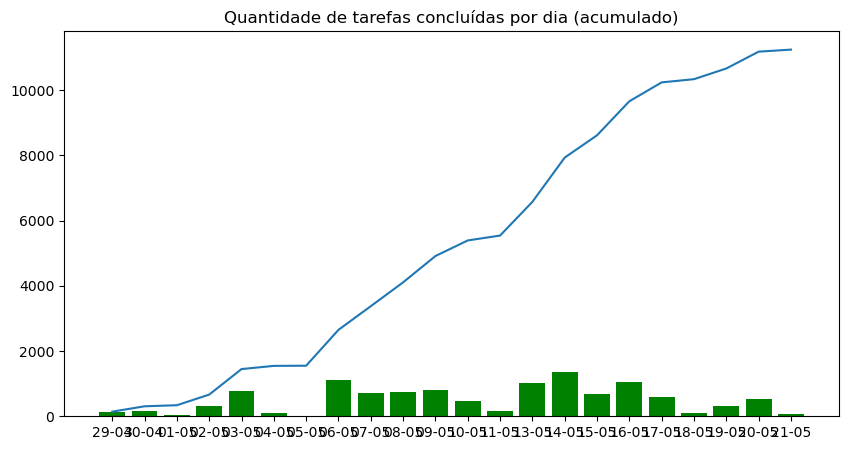

In [12]:
df_closed_on_date = df_labels[~df_labels['closed_on'].isna()][['closed_on','id']]
df_closed_on_date['closed_on'] = df_closed_on_date['closed_on'].dt.date
df_closed_on_date = df_closed_on_date.groupby('closed_on',as_index=False).count()
df_closed_on_date['acc'] = df_closed_on_date['id'].cumsum()

date = df_closed_on_date.iloc[:,0].values
date = df_closed_on_date.iloc[:,0].apply(lambda x: x.strftime('%d-%m'))

closed = df_closed_on_date.iloc[:,1].values
closed_acc = df_closed_on_date.iloc[:,2].values


fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date,closed_acc)
ax.bar(date,closed,color='green')
ax.set_title('Quantidade de tarefas concluídas por dia (acumulado)')
plt.show()

In [13]:
df_fiscal = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_fiscal = df_fiscal.pivot_table(index=['assigned_to', 'Unidade de Lotação'],columns='status',values='id',aggfunc='count')
df_fiscal = df_fiscal.fillna(0).astype('int')
df_fiscal['% Conclusão'] = df_fiscal['Concluída']/(df_fiscal.sum(axis=1))*100
df_fiscal['% Conclusão'] = df_fiscal['% Conclusão'].round(1)
df_fiscal = df_fiscal.sort_values(by='% Conclusão',ascending=False)
df_fiscal = df_fiscal.reset_index()

df_fiscal.columns = ['Fiscal', 'Unidade de Lotação', 'Concluída', 'Aberta', '% Conclusão']
df_fiscal

,Fiscal,Unidade de Lotação,Concluída,Aberta,% Conclusão
0,Williams Roosevelt Monjardim,UO021,1024,0,100.0
1,Marcos Rogerio Gianotto,UO072,1024,0,100.0
2,Josias Pereira de Barcelos,UO021,1024,0,100.0
3,José Luciano da Silva,GR06,1024,0,100.0
4,João Luis Alves Tavares,UO021,1024,0,100.0
5,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,786,238,76.8
6,Romildo Ignácio de Almeida,UO021,781,243,76.3
7,Cesar Alexandre Parazi,FIGF,701,323,68.5
8,Sebastião Rangel do Nascimento Silva,UO062,674,350,65.8
9,Eduardo Renato Rocha Brandão,GR02,634,390,61.9


In [14]:
df_fiscal[df_fiscal['Unidade de Lotação']=='UO021']

,Fiscal,Unidade de Lotação,Concluída,Aberta,% Conclusão
0,Williams Roosevelt Monjardim,UO021,1024,0,100.0
2,Josias Pereira de Barcelos,UO021,1024,0,100.0
4,João Luis Alves Tavares,UO021,1024,0,100.0
6,Romildo Ignácio de Almeida,UO021,781,243,76.3


In [15]:
df = df_issues[df_issues['assigned_to']=='Williams Roosevelt Monjardim'].sort_values(by='closed_on')
df['closed_on'] = df['closed_on'].dt.date
df['closed_on'].value_counts().sort_index()

closed_on
2024-05-06     10
2024-05-07    140
2024-05-08    106
2024-05-09     17
2024-05-10     65
2024-05-13     53
2024-05-14     79
2024-05-15      8
2024-05-16     81
2024-05-17     36
2024-05-18     28
2024-05-19    315
2024-05-20     86
Name: count, dtype: int64

In [16]:
df_unidade = df_labels[df_labels['assigned_to']!='Maxwel de Souza Freitas']
df_unidade = df_labels.pivot_table(index='Unidade de Lotação',columns='status',values='id',aggfunc='count')
df_unidade = df_unidade.fillna(0).astype('int')
df_unidade['% Conclusão'] = df_unidade['Concluída']/(df_unidade.sum(axis=1))*100
df_unidade['% Conclusão'] = df_unidade['% Conclusão'].round(1)
df_unidade = df_unidade.sort_values(by='% Conclusão',ascending=False)
df_unidade = df_unidade.reset_index()
df_unidade.columns = ['Unidade', 'Concluída', 'Aberta', '% Conclusão']
df_unidade

,Unidade,Concluída,Aberta,% Conclusão
0,GR06,1024,0,100.0
1,UO072,1024,0,100.0
2,UO021,3860,248,94.0
3,UO112,786,238,76.8
4,FIGF,701,323,68.5
5,UO062,674,350,65.8
6,GR02,634,390,61.9
7,GR05,537,487,52.4
8,UO073,502,522,49.0
9,UO071,437,587,42.7


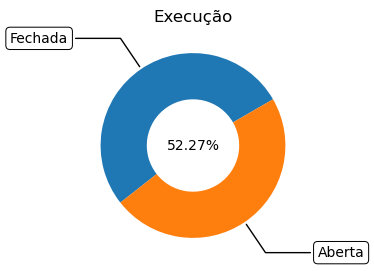

In [17]:
df_count = df_labels[['status','id']].groupby('status').count()
labels = [map_status[label] for label in df_count.index.values]
values = df_count.values.squeeze()
plot_donut(labels,values,'Execução',startangle=30)

In [18]:
with pd.ExcelWriter(FILE_RESULTS_REPORT) as writer:
    df_unidade.to_excel(writer, sheet_name='Unidade', index=False)
    df_fiscal.to_excel(writer, sheet_name='Fiscal', index=False)

## Preenchimento

Verificar se há incoerências no preenchimento, em especial nas perguntas sobre descrição. O campo do Fiscaliza que contém os dados do anúncio é denominado "Descrição" e pode confundir os fiscais durante a rotulagem.



In [19]:
df_labels[((df_labels['desc']==' ')
           &(df_labels['status']=='Concluída'))].pivot_table(
    index='Descrição identifica produto?',
    columns='Descrição bem elaborada?',
    values='id',aggfunc='count').fillna(0).astype('int')

Descrição bem elaborada?,Anúncio não possui descrição,Não,Sim
Descrição identifica produto?,,,
Anúncio não possui descrição,3983,13,3
Não,5,75,4
Sim,5,102,73


In [20]:
df_labels[((df_labels['desc']==' ')
           &(df_labels['status']=='Concluída')
           &(df_labels['Descrição bem elaborada?']=='Anúncio não possui descrição')
           &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
4154,amazon,Hoement Adaptador De Áudio Sem Fio Receptor Se...,,LABEL_PACP_2024_00004155,129370,Rotulagem de Dados,Concluída,2024-05-13 15:19:04,Eduardo Renato Rocha Brandão,GR02,0,1,Anúncio não possui descrição,Sim,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4224,amazon,Tampa traseira da bateria de substituição de t...,,LABEL_PACP_2024_00004225,129440,Rotulagem de Dados,Concluída,2024-05-13 13:08:11,Eduardo Renato Rocha Brandão,GR02,0,1,Anúncio não possui descrição,Não,Não,Não,Outro tipo/categoria (não listada acima)
8701,amazon,"Mini controle remoto com teclado MX3-M, contro...",,LABEL_PACP_2024_00008702,133917,Rotulagem de Dados,Concluída,2024-05-14 11:00:14,José Marcelo Mesquita de Sousa,GR09,0,1,Anúncio não possui descrição,Não,Sim,Sim,Outro tipo/categoria (não listada acima)
13187,amazon,"Maserfaliw Fone De Ouvido,C7 1pc Condu??O ¨®Ss...",,LABEL_PACP_2024_00013188,138403,Rotulagem de Dados,Concluída,2024-05-14 15:51:40,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,0,1,Anúncio não possui descrição,Não,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
13267,amazon,Eastdall Placa de Módulo Transmissor FM 0.7-9V...,,LABEL_PACP_2024_00013268,138483,Rotulagem de Dados,Concluída,2024-05-13 16:48:29,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1,1,Anúncio não possui descrição,Não,Sim,Sim,Transceptor de radiofrequência (VHF/UHF)
13296,amazon,Bateria de substituição XSP para alto-falante ...,,LABEL_PACP_2024_00013297,138512,Rotulagem de Dados,Concluída,2024-05-13 16:20:34,Oppenheimer Herbert Hans Medeiros Queiroz,UO112,1,1,Anúncio não possui descrição,Não,Sim,Não,Carregador ou fonte não destinada a celular
15196,amazon,"Conversor Scaler, conversor de áudio de vídeo ...",,LABEL_PACP_2024_00015197,140412,Rotulagem de Dados,Concluída,2024-05-17 12:34:46,Romildo Ignácio de Almeida,UO021,0,1,Anúncio não possui descrição,Sim,Não,Não,Outro tipo/categoria (não listada acima)
15214,amazon,Samsung Galaxy S8 + G955U 64GB GSM Desbloquead...,,LABEL_PACP_2024_00015215,140430,Rotulagem de Dados,Concluída,2024-05-17 12:20:37,Romildo Ignácio de Almeida,UO021,0,1,Anúncio não possui descrição,Sim,Sim,Sim,Smartphones
15320,amazon,"Tela Secundária Tipo C,monitor computador exib...",,LABEL_PACP_2024_00015321,140536,Rotulagem de Dados,Concluída,2024-05-16 14:04:55,Romildo Ignácio de Almeida,UO021,0,1,Anúncio não possui descrição,Sim,Não é possível afirmar,Não é possível afirmar,Outro tipo/categoria (não listada acima)
19271,amazon,Alomejor Bateria Transmissor RC 7.4V 2700mAh C...,,LABEL_PACP_2024_00019272,144487,Rotulagem de Dados,Concluída,2024-05-09 23:38:17,Thiago Antonio Alves,GR07,1,1,Anúncio não possui descrição,Sim,Não,Não,Bateria não destinada a celular


In [21]:
df_labels[((df_labels['desc']==' ')
           &(df_labels['status']=='Concluída')
           &(df_labels['Descrição bem elaborada?'].isin(['Sim','Não']))
           &(df_labels['Descrição identifica produto?'].isin(['Sim','Não'])))]

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
668,amazon,"Pico placa de expansão wi-fi, comunicação uart...",,LABEL_PACP_2024_00000669,126396,Rotulagem de Dados,Concluída,2024-05-20 12:38:56,Aécio Ramires de Mesquita,UO071,1,1,Sim,Sim,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
1518,amazon,Gigabyte X570 AORUS Elite Wi-Fi (AMD Ryzen 300...,,LABEL_PACP_2024_00001519,127246,Rotulagem de Dados,Concluída,2024-05-17 02:03:25,Carlos Juliano Pott,GR05,1,1,Sim,Sim,Sim,Sim,Computador ou notebook
1678,amazon,Carregador sem fio para carro BMW X3 G01 BMW X...,,LABEL_PACP_2024_00001679,127406,Rotulagem de Dados,Concluída,2024-05-15 17:54:04,Carlos Juliano Pott,GR05,1,1,Sim,Sim,Sim,Não é possível afirmar,Carregador para celular (inclusive powerbank)
1739,amazon,KJHBV 1 Par Amplificador De Sinal Yagi Antena ...,,LABEL_PACP_2024_00001740,127467,Rotulagem de Dados,Concluída,2024-05-15 15:30:24,Carlos Juliano Pott,GR05,0,0,Não,Não,Não é possível afirmar,Não é possível afirmar,Não é possível afirmar
1776,amazon,"Banco de energia do carregador, Carregamento r...",,LABEL_PACP_2024_00001777,127504,Rotulagem de Dados,Concluída,2024-05-15 01:57:12,Carlos Juliano Pott,GR05,0,0,Não,Não,Não é possível afirmar,Não é possível afirmar,Não é possível afirmar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,amazon,"Transceptor de Rádio, Transceptor de Rádio de ...",,LABEL_PACP_2024_00019453,144668,Rotulagem de Dados,Concluída,2024-04-29 20:35:20,Thiago Antonio Alves,GR07,1,1,Não,Não,Não é possível afirmar,Não é possível afirmar,Transceptor de radiofrequência (VHF/UHF)
19453,amazon,4G LTE Mobile WiFi Hotspot Desbloqueado Dispos...,,LABEL_PACP_2024_00019454,144669,Rotulagem de Dados,Concluída,2024-04-29 20:34:25,Thiago Antonio Alves,GR07,1,1,Sim,Sim,Sim,Sim,Modem celular (2G/3G/4G/5G)
21294,amazon,SOLUSTRE 2 Unidades Adaptador Transmissor Usb ...,,LABEL_PACP_2024_00021295,146510,Rotulagem de Dados,Concluída,2024-05-08 19:04:38,Williams Roosevelt Monjardim,UO021,0,0,Não,Não,Sim,Sim,Transceptor de radiação restrita (2.4GHz/5.8GHz)
21303,amazon,Peças de reparo de substituição da capa da bat...,,LABEL_PACP_2024_00021304,146519,Rotulagem de Dados,Concluída,2024-05-08 18:49:46,Williams Roosevelt Monjardim,UO021,1,1,Não,Não,Não,Não,Outro tipo/categoria (não listada acima)


In [22]:
df = df_labels[((df_labels['É passível homologação?']=='Não')
                &(df_labels['É transmissor de RF'].isin(['Sim','Não é possível afirmar'])))]
df

,marketplace,nome,desc,subject,id,tracker,status,closed_on,assigned_to,Unidade de Lotação,Título bem elaborado?,Título identifica o produto?,Descrição bem elaborada?,Descrição identifica produto?,É passível homologação?,É transmissor de RF,Qual o tipo do produto?
4018,mercadolivre,10 X Antenas Modulo Transceptor Mt7681 3dbi Es...,#NULLO#,LABEL_PACP_2024_00004019,129234,Rotulagem de Dados,Concluída,2024-05-16 18:05:33,Eduardo Renato Rocha Brandão,GR02,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Outro tipo/categoria (não listada acima)
4041,amazon,IIVVERR WIFI Pigtail Antena Cable RF1.37 IPEX ...,,LABEL_PACP_2024_00004042,129257,Rotulagem de Dados,Concluída,2024-05-15 19:11:56,Eduardo Renato Rocha Brandão,GR02,1,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Outro tipo/categoria (não listada acima)
4140,amazon,"Antena Bluetooth WiFi, 10 peças de antena FPC ...",,LABEL_PACP_2024_00004141,129356,Rotulagem de Dados,Concluída,2024-05-13 18:00:46,Eduardo Renato Rocha Brandão,GR02,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Outro tipo/categoria (não listada acima)
4157,amazon,"FOLOSAFENAR Cabo IPEX4 para SMA, estrutura est...",★Características do produto★: Este cabo IPEX4...,LABEL_PACP_2024_00004158,129373,Rotulagem de Dados,Concluída,2024-05-13 15:11:43,Eduardo Renato Rocha Brandão,GR02,0,1,Não,Sim,Não,Sim,Outro tipo/categoria (não listada acima)
4197,amazon,Caixa de Antena de Substituição de Antena Wi-F...,"1. Nova antena, antena omnidirecional de inter...",LABEL_PACP_2024_00004198,129413,Rotulagem de Dados,Concluída,2024-05-13 14:08:06,Eduardo Renato Rocha Brandão,GR02,0,1,Sim,Sim,Não,Sim,Outro tipo/categoria (não listada acima)
4239,mercadolivre,Transmissor Receptor Do Sistema De Guitarra Se...,Característica:\nTransmissor sem fio e compone...,LABEL_PACP_2024_00004240,129455,Rotulagem de Dados,Concluída,2024-05-13 12:33:53,Eduardo Renato Rocha Brandão,GR02,0,1,Sim,Sim,Não,Sim,Outro tipo/categoria (não listada acima)
4252,amazon,"Mouse Bluetooth, Mouse silencioso sem fio para...",,LABEL_PACP_2024_00004253,129468,Rotulagem de Dados,Concluída,2024-05-13 11:43:31,Eduardo Renato Rocha Brandão,GR02,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Outro tipo/categoria (não listada acima)
4269,amazon,PartyKindom 9 Pçs Antena Em Bastão De Cola De ...,,LABEL_PACP_2024_00004270,129485,Rotulagem de Dados,Concluída,2024-05-10 20:07:10,Eduardo Renato Rocha Brandão,GR02,0,1,Anúncio não possui descrição,Anúncio não possui descrição,Não,Sim,Outro tipo/categoria (não listada acima)
4275,magalu,Transmissor sem fios de arranque automático - ...,TRANSMISSOR SEM FIOS DE ARRANQUE AUTOMÁTICO - ...,LABEL_PACP_2024_00004276,129491,Rotulagem de Dados,Concluída,2024-05-10 19:44:03,Eduardo Renato Rocha Brandão,GR02,1,1,Sim,Sim,Não,Sim,Outro tipo/categoria (não listada acima)
4318,magalu,Kit Transmissor + Receptor 3 Canais Premium Ma...,A MarGirius está no mercado há mais de 70 anos...,LABEL_PACP_2024_00004319,129534,Rotulagem de Dados,Concluída,2024-05-10 16:22:11,Eduardo Renato Rocha Brandão,GR02,0,1,Sim,Sim,Não,Sim,Transceptor de radiofrequência (VHF/UHF)


In [23]:
for id in df.id:
    print(f'https://sistemas.anatel.gov.br/fiscaliza/issues/{id}')

https://sistemas.anatel.gov.br/fiscaliza/issues/129234
https://sistemas.anatel.gov.br/fiscaliza/issues/129257
https://sistemas.anatel.gov.br/fiscaliza/issues/129356
https://sistemas.anatel.gov.br/fiscaliza/issues/129373
https://sistemas.anatel.gov.br/fiscaliza/issues/129413
https://sistemas.anatel.gov.br/fiscaliza/issues/129455
https://sistemas.anatel.gov.br/fiscaliza/issues/129468
https://sistemas.anatel.gov.br/fiscaliza/issues/129485
https://sistemas.anatel.gov.br/fiscaliza/issues/129491
https://sistemas.anatel.gov.br/fiscaliza/issues/129534
https://sistemas.anatel.gov.br/fiscaliza/issues/129546
https://sistemas.anatel.gov.br/fiscaliza/issues/129603
https://sistemas.anatel.gov.br/fiscaliza/issues/129621
https://sistemas.anatel.gov.br/fiscaliza/issues/129705
https://sistemas.anatel.gov.br/fiscaliza/issues/134663
https://sistemas.anatel.gov.br/fiscaliza/issues/134723
https://sistemas.anatel.gov.br/fiscaliza/issues/134731
https://sistemas.anatel.gov.br/fiscaliza/issues/134795
https://si

## Resultados da rotulagem

In [24]:
columns_to_keep = ['id', 'nome', 'desc', 
                   'Título bem elaborado?', 'Título identifica o produto?',
                   'Descrição bem elaborada?', 'Descrição identifica produto?',
                   'É passível homologação?', 'É transmissor de RF', 'Qual o tipo do produto?']
df_items = df_labels[df_labels['status']=='Concluída'][columns_to_keep]
df_items = df_items.reset_index(drop=True)

map_columns = {'id': 'id', 'nome': 'nome', 'desc': 'desc', 
               'Título bem elaborado?': 'titulo_bem_elaborado', 'Título identifica o produto?': 'titulo_identifica_produto',
               'Descrição bem elaborada?': 'desc_bem_elaborada', 'Descrição identifica produto?': 'desc_identifica_produto',
               'É passível homologação?': 'passivel_homologacao', 'É transmissor de RF': 'transmissor_rf', 'Qual o tipo do produto?': 'tipo_produto'}
df_items.columns = df_items.columns.map(map_columns)

map_labels = {'Não': 0, 'Sim': 1, 'Não é possível afirmar': 3, 'Anúncio não possui descrição': 3}

df_items['titulo_bem_elaborado'] = df_items['titulo_bem_elaborado'].astype('int')
df_items['titulo_identifica_produto'] = df_items['titulo_identifica_produto'].astype('int')

df_items['desc_bem_elaborada'] = df_items['desc_bem_elaborada'].map(map_labels)
df_items['desc_identifica_produto'] = df_items['desc_identifica_produto'].map(map_labels)

df_items['passivel_homologacao'] = df_items['passivel_homologacao'].map(map_labels)
df_items['transmissor_rf'] = df_items['transmissor_rf'].map(map_labels)

df_items.to_parquet(FILE_ITEMS)

df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,126286,"Receptor Transmissor do Monitor da Orelha, Sis...",1. Som Premium: O circuito de RF do transmisso...,0,1,1,1,1,1,Transceptor de radiofrequência (VHF/UHF)
1,126287,Carregador Ipho Usb-C Chip Inteligente 4.8A Ma...,Carregador ipho usb-c chip inteligente 4.8a ma...,0,0,0,1,0,0,Outro tipo/categoria (não listada acima)
2,126288,Carregador Turbo Para Motorola G41 - Cabo E Fonte,*Kit Completo - Cabo 1 Metro e Carregador Turb...,1,1,1,1,1,0,Carregador para celular (inclusive powerbank)
3,126289,Mavic Pro P / Drones Rastreador Micro Gps Apl...,NOVO BLACK TRACKER GPS\n( ENVIAMOS FUNCIONANDO...,1,1,1,1,1,1,Transceptor de radiofrequência (VHF/UHF)
4,126290,Carregador Powerbank Ep-c855 32000mah Ecopower...,CARREGADOR ECOPOWER SMART CHARGE POWERBANK TUR...,1,1,1,1,1,0,Carregador para celular (inclusive powerbank)
...,...,...,...,...,...,...,...,...,...,...
11241,125715,CAIXA ACUSTICA PCX6500,,0,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
11242,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima)
11243,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
11244,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)


In [25]:
df_items.pivot_table(index='titulo_bem_elaborado', columns='titulo_identifica_produto', values='id', aggfunc='count')

titulo_identifica_produto,0,1
titulo_bem_elaborado,,
0,941,3628
1,189,6488


In [26]:
df_items.pivot_table(index='transmissor_rf', columns='passivel_homologacao', values='id', aggfunc='count').fillna(0).astype('int')

passivel_homologacao,0,1,3
transmissor_rf,,,
0,4415,1286,45
1,33,4553,17
3,5,46,846


In [27]:
df_resumo_tipo = df_items.pivot_table(index='tipo_produto',columns=['passivel_homologacao','transmissor_rf'],values='id',aggfunc='count').fillna(0).astype('int')
df_resumo_tipo['total'] = df_resumo_tipo.sum(axis=1)
df_resumo_tipo = df_resumo_tipo.sort_values(by='total',ascending=False)

df_resumo_tipo

passivel_homologacao                                   0           1        \
transmissor_rf                                         0   1  3    0     1   
tipo_produto                                                                 
Outro tipo/categoria (não listada acima)            3867  19  5  294   546   
Transceptor de radiação restrita (2.4GHz/5.8GHz)      14  10  0   19  1995   
Não é possível afirmar                               282   0  0    2    46   
Carregador para celular (inclusive powerbank)         13   0  0  620   169   
Smartphones                                            1   1  0   71   621   
Drone                                                  8   1  0   41   392   
Transceptor de radiofrequência (VHF/UHF)               1   1  0    0   254   
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)     0   1  0    2   244   
Bateria de lítio para celular                         24   0  0  181    41   
TV Box/TV Stick                                        2   0  0   17   128   
Carregador ou fonte não destinada a celular          105   0  0   16     7   
Bateria não destinada a celular                       61   0  0    7    11   
Computador ou notebook                                 3   0  0   12    39   
Peça ou acessório com fio para computador             34   0  0    4     5   
Reforçador/repetidor de sinal de celular (2G/3G...     0   0  0    0    31   
Modem celular (2G/3G/4G/5G)                            0   0  0    0    22   
Bloqueador de sinal de celular (jammer/FlipperZ...     0   0  0    0     2   

passivel_homologacao                                     3         total  
transmissor_rf                                       3   0  1    3        
tipo_produto                                                              
Outro tipo/categoria (não listada acima)            31  23  2  304  5091  
Transceptor de radiação restrita (2.4GHz/5.8GHz)     0   0  7    1  2046  
Não é possível afirmar                               4  15  3  523   875  
Carregador para celular (inclusive powerbank)        7   1  0    1   811  
Smartphones                                          0   0  1    0   695  
Drone                                                0   1  1    1   445  
Transceptor de radiofrequência (VHF/UHF)             0   0  0    1   257  
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz)   0   0  2    0   249  
Bateria de lítio para celular                        0   1  0    0   247  
TV Box/TV Stick                                      0   0  0    4   151  
Carregador ou fonte não destinada a celular          1   3  0    2   134  
Bateria não destinada a celular                      0   1  0    5    85  
Computador ou notebook                               1   0  0    2    57  
Peça ou acessório com fio para computador            0   0  0    1    44  
Reforçador/repetidor de sinal de celular (2G/3G...   0   0  1    1    33  
Modem celular (2G/3G/4G/5G)                          0   0  0    0    22  
Bloqueador de sinal de celular (jammer/FlipperZ...   2   0  0    0     4

### Títulos

In [28]:
df_items['doc'] = df_items['nome'].map(clean_text)
df_items['tokens'] = df_items['nome'].apply(lambda doc: clean_text(doc, return_tokens=True))
df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,doc,tokens
0,126286,"Receptor Transmissor do Monitor da Orelha, Sis...",1. Som Premium: O circuito de RF do transmisso...,0,1,1,1,1,1,Transceptor de radiofrequência (VHF/UHF),receptor transmissor monitor orelha sistema fi...,"[receptor, transmissor, monitor, orelha, siste..."
1,126287,Carregador Ipho Usb-C Chip Inteligente 4.8A Ma...,Carregador ipho usb-c chip inteligente 4.8a ma...,0,0,0,1,0,0,Outro tipo/categoria (não listada acima),carregador ipho usb-c chip inteligente 4.8a ma...,"[carregador, ipho, usb-c, chip, inteligente, 4..."
2,126288,Carregador Turbo Para Motorola G41 - Cabo E Fonte,*Kit Completo - Cabo 1 Metro e Carregador Turb...,1,1,1,1,1,0,Carregador para celular (inclusive powerbank),carregador turbo motorola g41 cabo fonte,"[carregador, turbo, motorola, g41, cabo, fonte]"
3,126289,Mavic Pro P / Drones Rastreador Micro Gps Apl...,NOVO BLACK TRACKER GPS\n( ENVIAMOS FUNCIONANDO...,1,1,1,1,1,1,Transceptor de radiofrequência (VHF/UHF),mavic pro p drones rastreador micro gps aplica...,"[mavic, pro, p, drones, rastreador, micro, gps..."
4,126290,Carregador Powerbank Ep-c855 32000mah Ecopower...,CARREGADOR ECOPOWER SMART CHARGE POWERBANK TUR...,1,1,1,1,1,0,Carregador para celular (inclusive powerbank),carregador powerbank ep-c855 32000mah ecopower...,"[carregador, powerbank, ep-c855, 32000mah, eco..."
...,...,...,...,...,...,...,...,...,...,...,...,...
11241,125715,CAIXA ACUSTICA PCX6500,,0,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),caixa acustica pcx6500,"[caixa, acustica, pcx6500]"
11242,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),conector cauda celular 10 pcs carregando conec...,"[conector, cauda, celular, 10, pcs, carregando..."
11243,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),avantree medley clear fones ouvido fio ouvir t...,"[avantree, medley, clear, fones, ouvido, fio, ..."
11244,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,3,3,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),hilitand adaptador fio placa rede fio adaptado...,"[hilitand, adaptador, fio, placa, rede, fio, a..."


### Bem elaborados x Mal elaborados

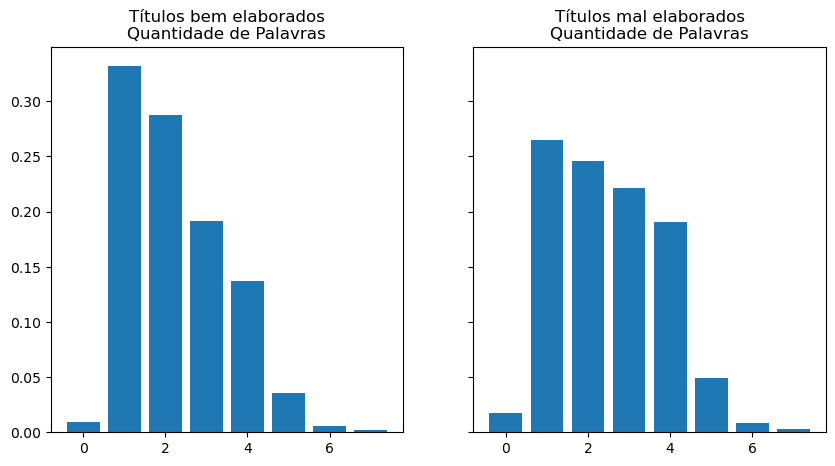

In [29]:
t_bem_elaborados = df_items[df_items['titulo_bem_elaborado']==1]['tokens']
t_mal_elaborados = df_items[df_items['titulo_bem_elaborado']==0]['tokens']

len_t_bem_elaborados = [len(doc) for doc in t_bem_elaborados]
len_t_mal_elaborados = [len(doc) for doc in t_mal_elaborados]

bins = [0,5,10,15,20,25,30,35,50]
h_len_t_bem_elaborados,_ = np.histogram(len_t_bem_elaborados,bins=bins)
h_len_t_mal_elaborados,_ = np.histogram(len_t_mal_elaborados,bins=bins)

h_len_t_bem_elaborados=h_len_t_bem_elaborados/h_len_t_bem_elaborados.sum()
h_len_t_mal_elaborados=h_len_t_mal_elaborados/h_len_t_mal_elaborados.sum()

fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
x=range(len(bins)-1)
ax[0].bar(x,h_len_t_bem_elaborados)
ax[0].set_title('Títulos bem elaborados\nQuantidade de Palavras')
ax[1].bar(x,h_len_t_mal_elaborados)
ax[1].set_title('Títulos mal elaborados\nQuantidade de Palavras')

plt.show()

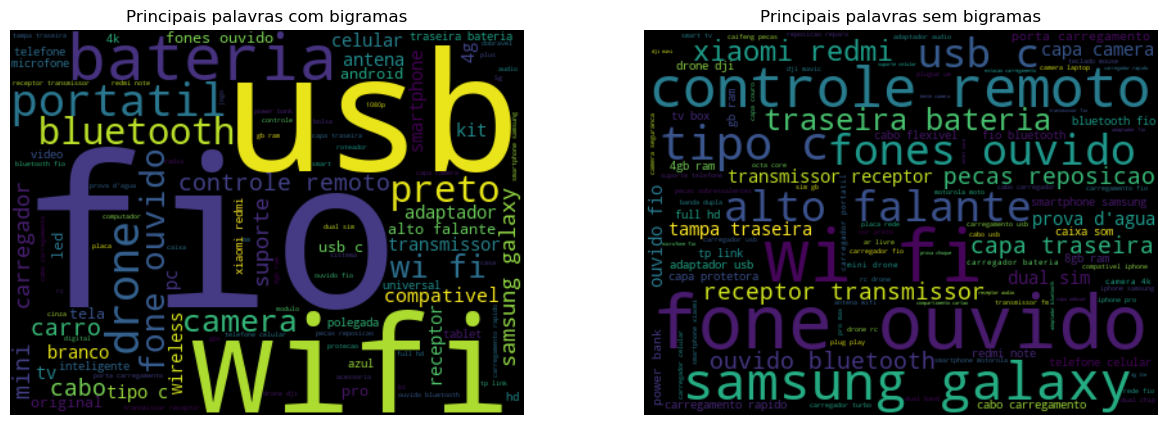

In [30]:
from functions import plot_wordcloud

f_t_bem_elaborados = [token for row in t_bem_elaborados for token in row]
f_t_mal_elaborados = [token for row in t_mal_elaborados for token in row]

plot_wordcloud(f_t_bem_elaborados,100)

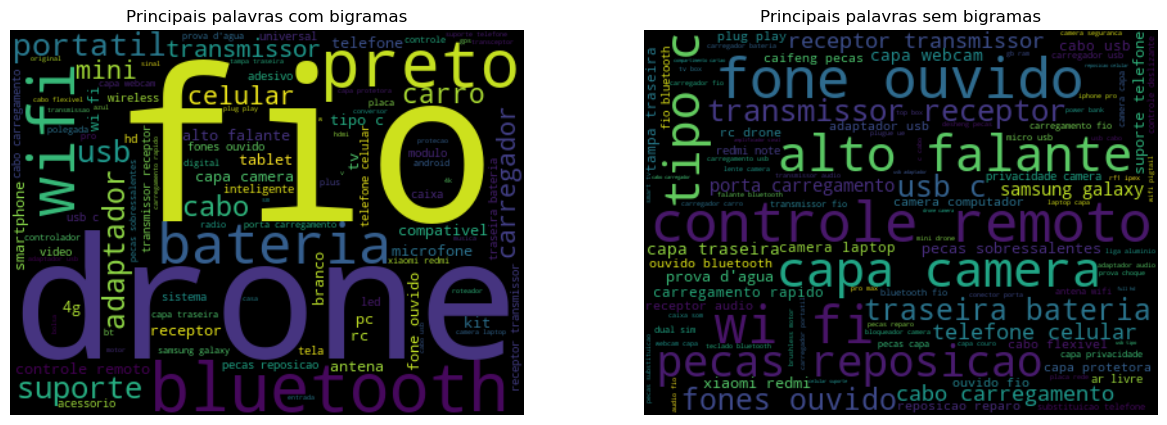

In [31]:
plot_wordcloud(f_t_mal_elaborados,100)

### Produtos passíveis de homologação vs não passíveis

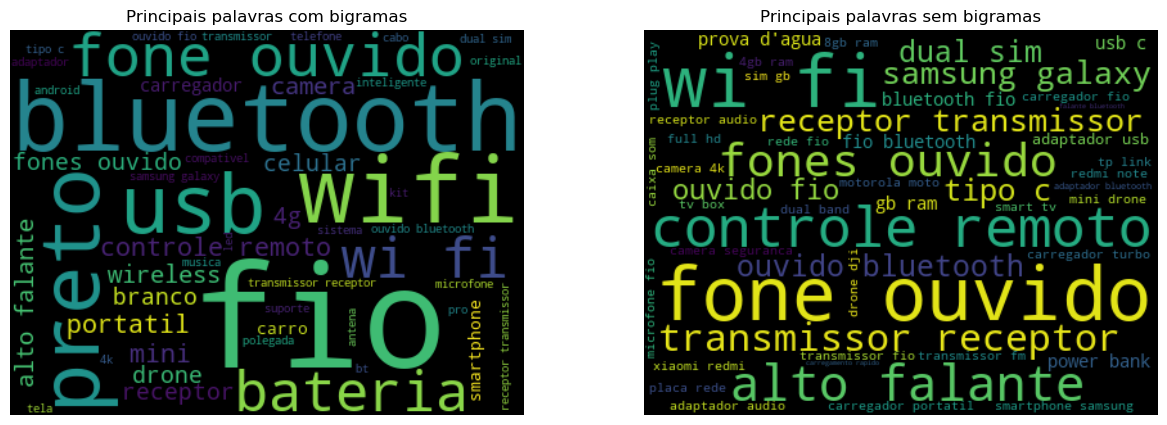

In [32]:
t_passiveis = df_items[df_items['passivel_homologacao']==1]['doc']
t_nao_passiveis = df_items[df_items['passivel_homologacao']==0]['doc']

plot_wordcloud(t_passiveis)

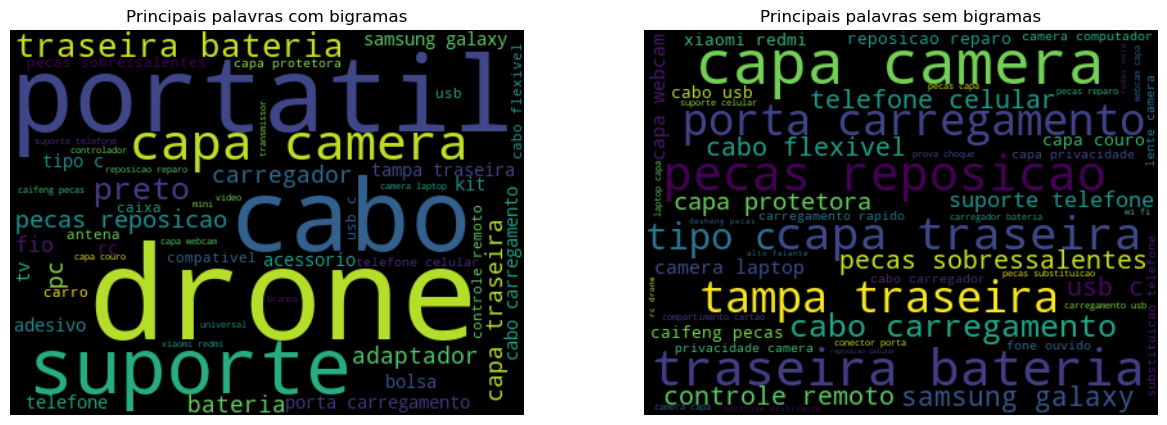

In [33]:
plot_wordcloud(t_nao_passiveis)

### Transmissores de rf vs não transmissores

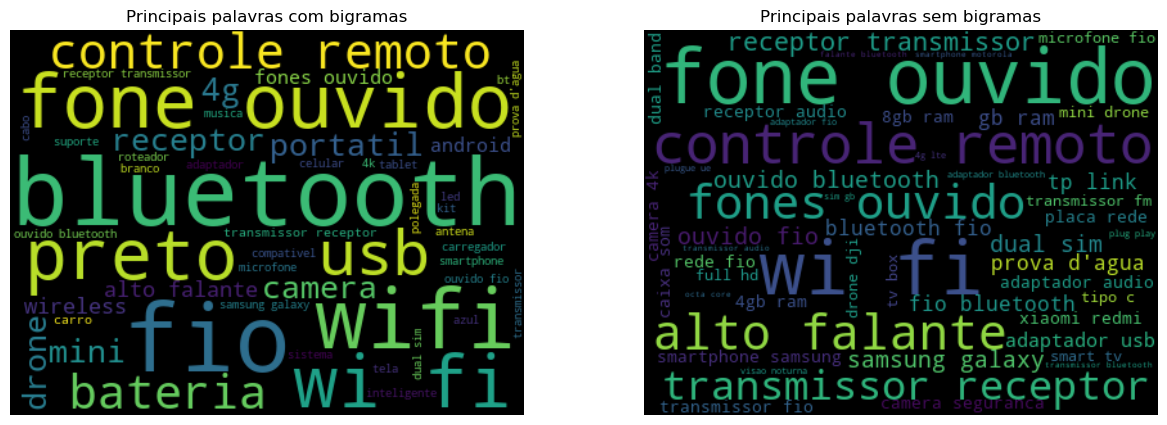

In [34]:
t_transmissor_rf = df_items[df_items['transmissor_rf']==1]['doc']
t_nao_transmissor_rf = df_items[df_items['transmissor_rf']==0]['doc']

plot_wordcloud(t_transmissor_rf)

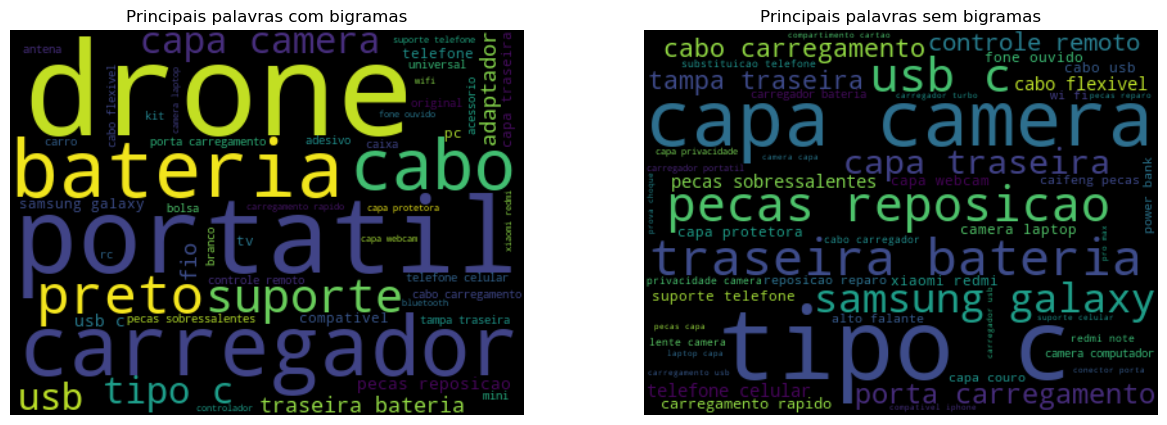

In [35]:
plot_wordcloud(t_nao_transmissor_rf)